# Small business loan prediction project

The goal of my project is to help new entrepreneurs with their main financial decision: Which bank should they ask for the capital to start their business?

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import folium
import os
import json
import numpy as np

Reads in the data and saves it the a pickle file. Use it only the very first time. Link to data https://www.sba.gov/about-sba/sba-performance/open-government/foia/frequently-requested-records/sba-7a-504-loan-data-reports.

In [6]:
files = ['FOIA - 7(a)(FY1991-FY1999).xlsx', 'FOIA - 7(a)(FY2000-FY2009).xlsx', 'FOIA - 7(a)(FY2010-Present).xlsx']
sbloan_data = pd.concat([pd.read_excel(f, dtypes = {'BorrZip':'str', 'BankZip':'str'}) for f in files], ignore_index=True)
sbloan_data.to_pickle('SBL_dataset.pkl')

Reads in the data from the pickle file.

In [3]:
sbloan_data = pd.read_pickle('SBL_dataset.pkl')
sbloan_data.dtypes

Program                          object
BorrName                         object
BorrStreet                       object
BorrCity                         object
BorrState                        object
BorrZip                           int64
BankName                         object
BankStreet                       object
BankCity                         object
BankState                        object
BankZip                          object
GrossApproval                     int64
SBAGuaranteedApproval             int64
ApprovalDate             datetime64[ns]
ApprovalFiscalYear                int64
FirstDisbursementDate    datetime64[ns]
DeliveryMethod                   object
subpgmdesc                       object
InitialInterestRate             float64
TermInMonths                      int64
NaicsCode                       float64
NaicsDescription                 object
FranchiseCode                    object
FranchiseName                    object
ProjectCounty                    object


Which businesses have the highest number of approved loans. Combines the name of the company with the zip code to create a unique identifier.

In [30]:
sbloan_data['Name_Zip'] = sbloan_data.BorrName + sbloan_data.BorrZip.astype('str')
loan_counts_perborrower = sbloan_data[sbloan_data['NaicsCode'].notnull()][['Name_Zip', 'GrossApproval']].groupby('Name_Zip', as_index = False).count()
loan_counts_perborrower.sort_values('GrossApproval', ascending = False)
# sbloan_data[sbloan_data.BorrName.notnull() & sbloan_data.BorrName.str.contains('QUIZNO')]# [['BorrName','BorrStreet','BorrCity','BorrState','BorrZip']]

,Name_Zip,GrossApproval
689722,"Meathead Movers, Inc.93401",107
1093067,WEST TEXAS LEE CO INC79329,53
1038238,"The Cove at River Oaks, LLC93446",41
836115,"REGENT FLOORS, INC.15137",38
334233,"ERIE PETROLEUM, INC.16512",29
160011,"Briar Rose Estates, LLC93444",26
957799,Silly Zak's Gluten Free Bakery97502,21
1033584,"Taylor Machine, Inc55014",21
204892,"COLCHESTER HOLDINGS, INC.13755",19
974496,"Sulta Manufacturing Company, I75482",19


Creates a dictionary from the low level NAICS codes and their description.

In [128]:
notnull_naics = sbloan_data[sbloan_data['NaicsCode'].notnull()]
naics_dict = dict(zip(notnull_naics.NaicsCode,notnull_naics.NaicsDescription))

In [129]:
naics_dict

{811121.0: 'Automotive Body, Paint, and Interior Repair and Maintenance',
 422330.0: "Women's, Children's, and Infants' Clothing and Accessories Wholesalers",
 442210.0: 'Floor Covering Stores',
 624310.0: 'Vocational Rehabilitation Services',
 421830.0: 'Industrial Machinery and Equipment Wholesalers',
 323121.0: 'Tradebinding and Related Work',
 422510.0: 'Grain and Field Bean Wholesalers',
 421990.0: 'Other Miscellaneous Durable Goods Wholesalers',
 811111.0: 'General Automotive Repair',
 453110.0: 'Florists',
 541330.0: 'Engineering Services',
 624410.0: 'Child Day Care Services',
 334412.0: 'Bare Printed Circuit Board Manufacturing',
 541940.0: 'Veterinary Services',
 621310.0: 'Offices of Chiropractors',
 334413.0: 'Semiconductor and Related Device Manufacturing',
 334113.0: 'Computer Terminal Manufacturing',
 421510.0: 'Metal Service Centers and Offices',
 421690.0: 'Other Electronic Parts and Equipment Wholesalers',
 561510.0: 'Travel Agencies',
 621320.0: 'Offices of Optometri

Finds the amount of each loan as a function of the year they were approved.

Text(0,0.5,'Average approved amount')

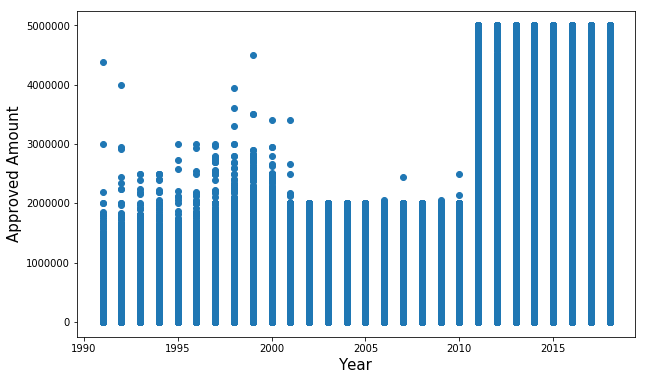

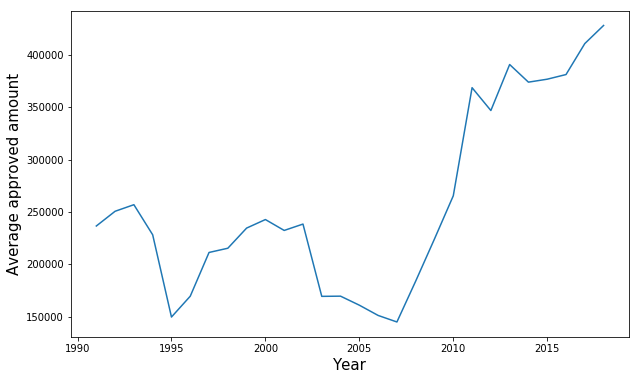

In [241]:
plt.figure(figsize=(10,6))
plt.scatter(sbloan_data['ApprovalFiscalYear'], sbloan_data['GrossApproval'])
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Approved Amount', fontsize = 15)
yearwise = sbloan_data[['ApprovalFiscalYear', 'GrossApproval']].groupby('ApprovalFiscalYear', as_index = False).sum().merge(sbloan_data[['ApprovalFiscalYear', 'GrossApproval']].groupby('ApprovalFiscalYear').count(), on='ApprovalFiscalYear', how = 'inner')
yearwise['Average'] = yearwise['GrossApproval_x']/yearwise['GrossApproval_y']
plt.figure(figsize=(10,6))
plt.plot(yearwise.ApprovalFiscalYear, yearwise.Average)
# print(yearwise.GrossApproval_y.sum())
# sbloan_data.shape[0]
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Average approved amount', fontsize = 15)

Checks what is the distribution of the term of the loans.

Text(0,0.5,'Frequency')

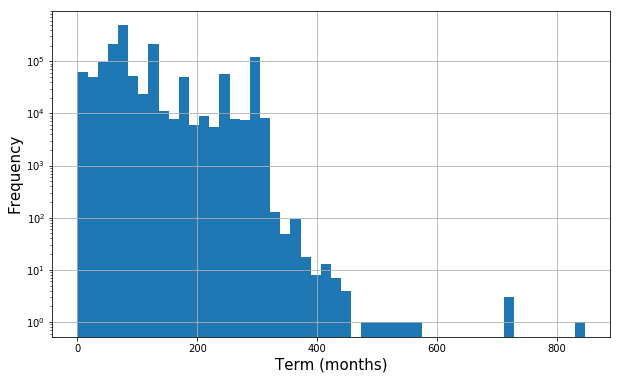

In [37]:
plt.figure(figsize=(10,6))
sbloan_data['TermInMonths'].hist(bins = 50, log = True)
plt.xlabel('Term (months)', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

Inspects the outliers. It turns out that most of them were cancelled, although one is still active. It was approved in 2016.

In [34]:
term_in_months = sbloan_data[sbloan_data['TermInMonths'] > 700]
term_in_months

,Program,BorrName,BorrStreet,BorrCity,BorrState,BorrZip,BankName,BankStreet,BankCity,BankState,...,ProjectCounty,ProjectState,SBADistrictOffice,CongressionalDistrict,BusinessType,LoanStatus,ChargeOffDate,GrossChargeOffAmount,RevolverStatus,JobsSupported
1084082,7A,"CHAD ALLAN CONSULTING, LLC",780 EAST SMITH RD,MEDINA,OH,44256,The Huntington National Bank,17 S High St,COLUMBUS,OH,...,MEDINA,OH,CLEVELAND DISTRICT OFFICE,16.0,CORPORATION,CANCLD,NaT,0,1,7
1091492,7A,Eye Win LLC,2302 St Andrew Ct,Goddard,KS,67052,"INTRUST Bank, National Association",105 N Main St,WICHITA,KS,...,SEDGWICK,KS,WICHITA DISTRICT OFFICE,4.0,CORPORATION,CANCLD,NaT,0,1,2
1396763,7A,BHAGWANDAS JEWELERS LLC,1400 Berlin Road,CHERRY HILL,NJ,8003,"Citizens Bank, National Association",1 Citizens Plaza,PROVIDENCE,RI,...,CAMDEN,NJ,NEW JERSEY DISTRICT OFFICE,1.0,CORPORATION,CANCLD,NaT,0,0,2
1400957,7A,Birchcrest Holdings LLC,5183 Mayfield Road,Lyndhurst,OH,44124,The Huntington National Bank,17 S High St,COLUMBUS,OH,...,CUYAHOGA,OH,CLEVELAND DISTRICT OFFICE,14.0,CORPORATION,EXEMPT,NaT,0,0,25


In [29]:
term_in_months[['TermInMonths','GrossApproval','NaicsDescription', 'BorrName', 'ApprovalDate', 'LoanStatus']]

,TermInMonths,GrossApproval,NaicsDescription,BorrName,ApprovalDate,LoanStatus
1084082,720,100000,Public Relations Agencies,"CHAD ALLAN CONSULTING, LLC",2010-11-29,CANCLD
1091492,720,50000,Electronic Shopping,Eye Win LLC,2010-12-23,CANCLD
1396763,847,46000,Jewelry Stores,BHAGWANDAS JEWELERS LLC,2016-09-26,CANCLD
1400957,720,63400,HMO Medical Centers,Birchcrest Holdings LLC,2016-10-20,EXEMPT


Term histogram for small loans.

Text(0,0.5,'Frequency')

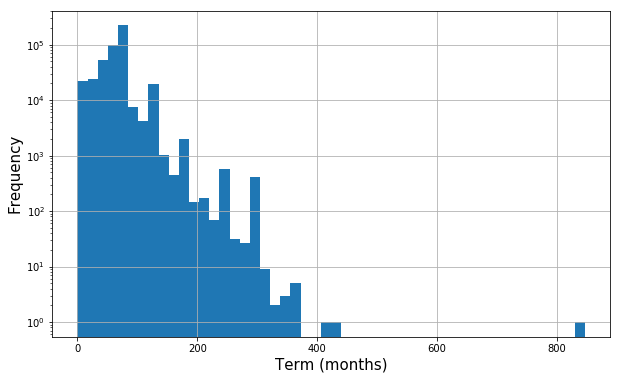

In [39]:
grossapp = sbloan_data[sbloan_data['GrossApproval'] < 50000]
plt.figure(figsize=(10,6))
grossapp['TermInMonths'].hist(bins = 50, log = True)
plt.xlabel('Term (months)', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

Term histogram for large loans.

Text(0,0.5,'Frequency')

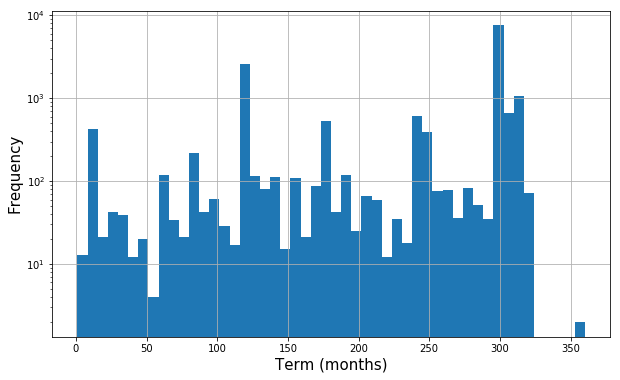

In [42]:
grossapp = sbloan_data[sbloan_data['GrossApproval'] > 2000000]
plt.figure(figsize=(10,6))
grossapp['TermInMonths'].hist(bins = 50, log = True)
plt.xlabel('Term (months)', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)

Statewide comparison sorted based on avergae amount / loan. GrossApproval_x -> total amount, GrossApproval_y -> No of loans

,GrossApproval_x,GrossApproval_y,Average
ProjectState,,,
MP,12126500,28,433089.285714
GA,15671391902,38117,411139.174174
SC,3465166370,10186,340189.119380
AZ,9688564785,29906,323967.256905
CA,63808996452,199398,320008.206963
TX,35670621595,119733,297918.047614
NC,7245663262,24466,296152.344560
AK,1038271960,3537,293545.931580
CO,9755462279,34016,286790.400958


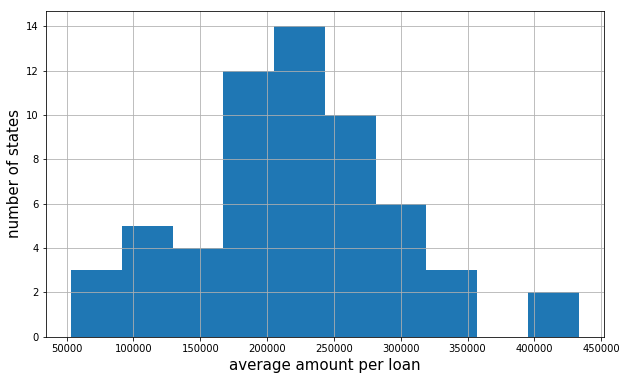

In [43]:
statewide = sbloan_data[['ProjectState', 'GrossApproval']].groupby('ProjectState').sum().merge(sbloan_data[['ProjectState', 'GrossApproval']].groupby('ProjectState').count(), on='ProjectState', how = 'inner')
statewide.columns
statewide['Average'] = statewide['GrossApproval_x']/statewide['GrossApproval_y']
plt.figure(figsize=(10,6))
statewide['Average'].hist()
plt.xlabel('average amount per loan', fontsize=15)
plt.ylabel('number of states', fontsize=15)
statewide[statewide['Average'] < 100000]
statewide.sort_values(['Average'], ascending = False)

          

Creates a map using the folium package that shows the average amount per approved loans for four different intervals.

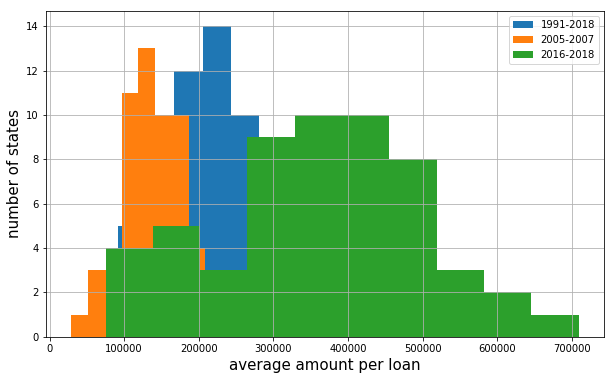

In [4]:
plt.figure(figsize=(10,6))
statewide = sbloan_data[['ProjectState', 'GrossApproval']].groupby('ProjectState', as_index = False).sum().merge(sbloan_data[['ProjectState', 'GrossApproval']].groupby('ProjectState').count(), on='ProjectState', how = 'inner')
statewide.columns
statewide['Average'] = statewide['GrossApproval_x']/statewide['GrossApproval_y']
# print('Statewide', statewide.shape)
# print(statewide['GrossApproval_x'].sum(), sbloan_data['GrossApproval'].sum())
# print(sbloan_data['GrossApproval'].sum()/sbloan_data.shape[0])
# print(statewide[statewide.ProjectState == 'GA'])
statewide['Average'].hist(label = '1991-2018')

state_unemployment = os.path.join('data', 'US_Unemployment_Oct2012.csv')
state_data = pd.read_csv(state_unemployment)
# print(state_data.shape)

# Economic crisis : https://www.nber.org/cycles.html
# March 2001 - November 2001
# December 2007 - June 2009

range1 = [2005, 2006, 2007]
statewide_2005_2007 = sbloan_data[sbloan_data['ApprovalFiscalYear'].isin(range1)][['ProjectState', 'GrossApproval']].groupby('ProjectState', as_index = False).sum().merge(sbloan_data[sbloan_data['ApprovalFiscalYear'].isin(range1)][['ProjectState', 'GrossApproval']].groupby('ProjectState').count(), on='ProjectState', how = 'inner')
statewide.columns
statewide_2005_2007['Average'] = statewide_2005_2007['GrossApproval_x']/statewide_2005_2007['GrossApproval_y']
# print('Statewide', statewide.shape)
statewide_2005_2007['Average'].hist(label = '2005-2007')
# print(statewide_2005_2007[statewide_2005_2007.ProjectState == 'GA'])

range2 = [2008, 2009]
statewide_2008_2009 = sbloan_data[sbloan_data['ApprovalFiscalYear'].isin(range2)][['ProjectState', 'GrossApproval']].groupby('ProjectState', as_index = False).sum().merge(sbloan_data[sbloan_data['ApprovalFiscalYear'].isin(range2)][['ProjectState', 'GrossApproval']].groupby('ProjectState').count(), on='ProjectState', how = 'inner')
statewide.columns
statewide_2008_2009['Average'] = statewide_2008_2009['GrossApproval_x']/statewide_2008_2009['GrossApproval_y']
# print('Statewide', statewide.shape)
# print(statewide_2008_2009[statewide_2008_2009.ProjectState == 'GA'])

range3 = [2016, 2018]
statewide_2016_2018 = sbloan_data[sbloan_data['ApprovalFiscalYear'].isin(range3)][['ProjectState', 'GrossApproval']].groupby('ProjectState', as_index = False).sum().merge(sbloan_data[sbloan_data['ApprovalFiscalYear'].isin(range3)][['ProjectState', 'GrossApproval']].groupby('ProjectState').count(), on='ProjectState', how = 'inner')
statewide.columns
statewide_2016_2018['Average'] = statewide_2016_2018['GrossApproval_x']/statewide_2016_2018['GrossApproval_y']
# print('Statewide', statewide.shape)
# print(statewide_2016_2018[statewide_2016_2018.ProjectState == 'GA'])
statewide_2016_2018['Average'].hist(label = '2016-2018')

state_geo = os.path.join('data', 'us-states.json')
m = folium.Map(location=[43, -102], zoom_start=4.3)

m.choropleth(
    geo_data=state_geo,
    name='total loan amount',
    data=statewide,
    columns=['ProjectState', 'Average'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name='Average amount per loan (1991-2018)'
)

m.choropleth(
    geo_data=state_geo,
    name='loan amount 2005-2007',
    data=statewide_2005_2007,
    columns=['ProjectState', 'Average'],
    key_on='feature.id',
    fill_color='GnBu',
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name='Average amount per loan (2005-2007)'
)


m.choropleth(
    geo_data=state_geo,
    name='loan amount 2008-2009',
    data=statewide_2008_2009,
    columns=['ProjectState', 'Average'],
    key_on='feature.id',
    fill_color='RdPu',
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name='Average amount per loan (2008-2009)'
)

m.choropleth(
    geo_data=state_geo,
    name='loan amount 2016-2018',
    data=statewide_2016_2018,
    columns=['ProjectState', 'Average'],
    key_on='feature.id',
    fill_color='BuGn',
    fill_opacity=0.5,
    line_opacity=0.2,
    legend_name='Average amount per loan (2016-2018)'
)
plt.legend()
plt.xlabel('average amount per loan', fontsize=15)
plt.ylabel('number of states', fontsize=15)


folium.LayerControl().add_to(m)
m.save('loans_per_state.html')
m

From the previous graph it was clear that Georgia's value was one of the highest in all intervals. Checks how it changed over time.

    ApprovalFiscalYear  GrossApproval_x  GrossApproval_y
0                 1991       1127371601             3430
1                 1992       1312831198             3751
2                 1993       1173396563             3581
3                 1994       1398128159             4236
4                 1995       1287057736             5605
5                 1996       1354890962             5530
6                 1997       1924680974             6470
7                 1998       1744137025             6869
8                 1999       1940675946             6872
9                 2000       1986392423             6219
10                2001       1776762666             5790
11                2002       2546015812             8047
12                2003       2256784475            10713
13                2004       2659967838            12247
14                2005       2668327952            11731
15                2006       2446550781            12680
16                2007       24

Text(0,0.5,'Average approved amount in GA')

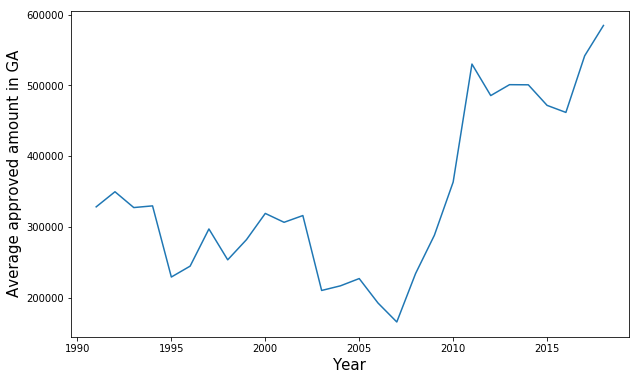

In [248]:
GA = sbloan_data[sbloan_data.ProjectState == 'GA']
yearwise = GA[['ApprovalFiscalYear', 'GrossApproval']].groupby('ApprovalFiscalYear', as_index = False).sum().merge(GA[['ApprovalFiscalYear', 'GrossApproval']].groupby('ApprovalFiscalYear').count(), on='ApprovalFiscalYear', how = 'inner')
print(yearwise)
yearwise['Average'] = yearwise['GrossApproval_x']/yearwise['GrossApproval_y']
plt.figure(figsize=(10,6))
plt.plot(yearwise.ApprovalFiscalYear, yearwise.Average)
# print(yearwise.GrossApproval_y.sum())
# sbloan_data.shape[0]
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Average approved amount in GA', fontsize = 15)

In [233]:
import inspect
inspect.signature(m.choropleth)

<Signature (geo_data, data=None, columns=None, key_on=None, threshold_scale=None, fill_color='blue', fill_opacity=0.6, line_color='black', line_weight=1, line_opacity=1, name=None, legend_name='', topojson=None, reset=False, smooth_factor=None, highlight=None)>

A function to plot trends in the number of loans approved and their average amount.

In [53]:
def plottingtrends(loan_data, title):

    yearly = loan_data[['ApprovalFiscalYear', 'GrossApproval']].groupby('ApprovalFiscalYear', as_index = False).count()
    yearly_paid_exempt_undis = loan_data[loan_data['LoanStatus'].isin(['COMMIT','PIF','EXEMPT'])][['ApprovalFiscalYear', 'GrossApproval']].groupby('ApprovalFiscalYear', as_index = False).count()
    fig = plt.figure(figsize=(10,5))
    ax = plt.subplot(121)
#     pos1 = ax.get_position() # get the original position 
#     print(pos1)
#     ax.set_position(pos1)#[0.1, 0.1, 0.4, 0.8])
    plt.plot(yearly.ApprovalFiscalYear, yearly.GrossApproval, label = 'all loans')
    plt.plot(yearly_paid_exempt_undis.ApprovalFiscalYear, yearly_paid_exempt_undis.GrossApproval, label = 'loans not cancelled or charged off')
    plt.legend()
    plt.title(title, fontsize=10, loc='left')
    
    
    #ax.set_position(pos2) # set a new position
    
    plt.xlabel('year', fontsize=15)
    plt.ylabel('no. of loans approved', fontsize=15)

    ax2 = plt.subplot(122)
#     pos1 = ax2.get_position() # get the original position 
#     pos2 = [pos1.x0, pos1.y0,  pos1.width, pos1.height-0.5] 
#     #pos1.height = pos1.height -0.3
#     ax2.set_position(pos1)#[0.55, 0.1, 0.8, 0.8])
    yearly_sum = loan_data[['ApprovalFiscalYear', 'GrossApproval']].groupby('ApprovalFiscalYear', as_index = False).sum()
    yearly_paid_exempt_undis_sum = loan_data[loan_data['LoanStatus'].isin(['COMMIT','PIF','EXEMPT'])][['ApprovalFiscalYear', 'GrossApproval']].groupby('ApprovalFiscalYear', as_index = False).sum()
    plt.plot(yearly_sum.ApprovalFiscalYear, yearly_sum.GrossApproval/yearly.GrossApproval, label = 'all loans')
    plt.plot(yearly_paid_exempt_undis_sum.ApprovalFiscalYear, yearly_paid_exempt_undis_sum.GrossApproval/yearly_paid_exempt_undis.GrossApproval , label = 'loans not cancelled or charged off')
    plt.xlabel('year', fontsize=15)
    plt.ylabel('total amount / loans approved', fontsize=15)
    plt.legend()
    
    fig.tight_layout()
    fig.savefig(os.path.join('Results',title+'.pdf'))
    

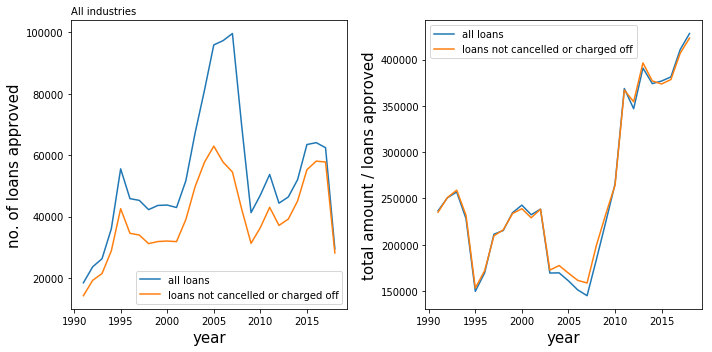

In [273]:
plottingtrends(sbloan_data, 'All industries')

In [39]:
sbloan_data['ApprovalFiscalYear'].unique()

array([1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018])

Reads in the higher level NAICS codes datafile.

In [49]:
naicsCodes = pd.read_csv('NaicsCodes_highlevel.txt')
naicsCodes

,Code,IndustryTitle,NoBusinessEst
0,11,Agriculture Forestry Fishing and Hunting,348550
1,21,Mining,28732
2,22,Utilities,34615
3,23,Construction,1369268
4,31,Manufacturing,604541
5,32,Manufacturing,604541
6,33,Manufacturing,604541
7,42,Wholesale Trade,679448
8,44,Retail Trade,1665458
9,45,Retail Trade,1665458


Creates dictionaries for an easy lookup.

In [51]:
naicsCode_highlevel = dict(zip(naicsCodes.Code, naicsCodes.IndustryTitle))
naicsCode_highlevel[0] = ''
naicsCode_highlevel[99] = 'Mystery Industry'
Industries = dict(zip(naicsCodes.IndustryTitle, naicsCodes.NoBusinessEst))
sbloan_data['Industry'] = sbloan_data['NaicsCode'].apply(lambda x: naicsCode_highlevel[int(x//10000)] if pd.notnull(x) else 0)

Plots the trends for all industries using the above defined function.

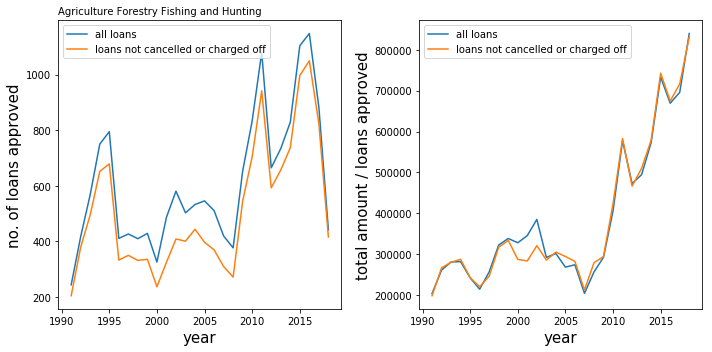

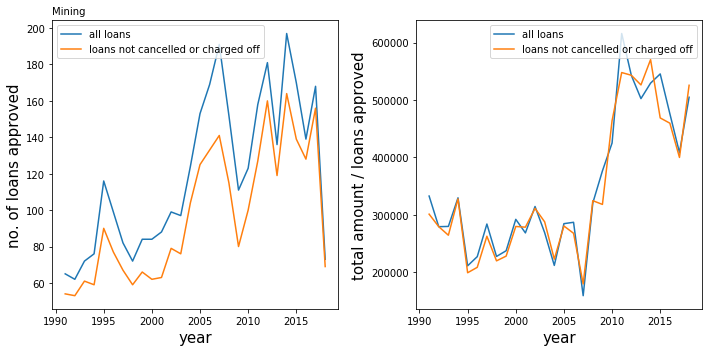

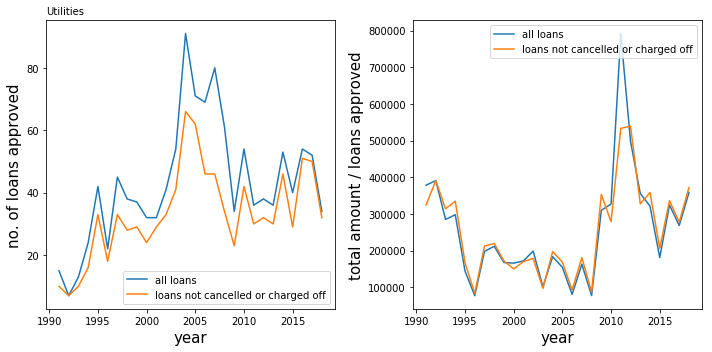

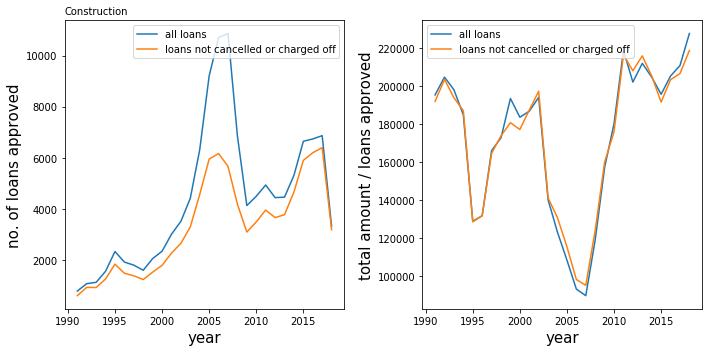

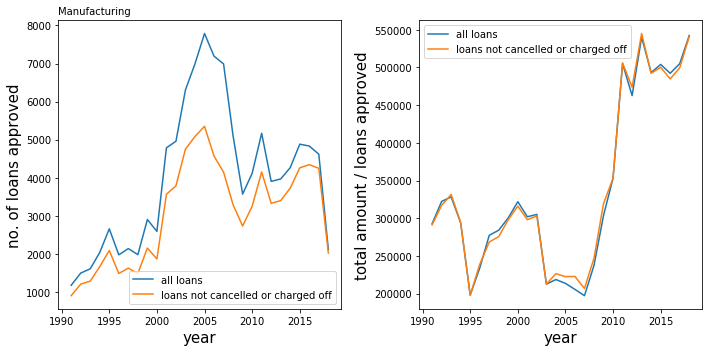

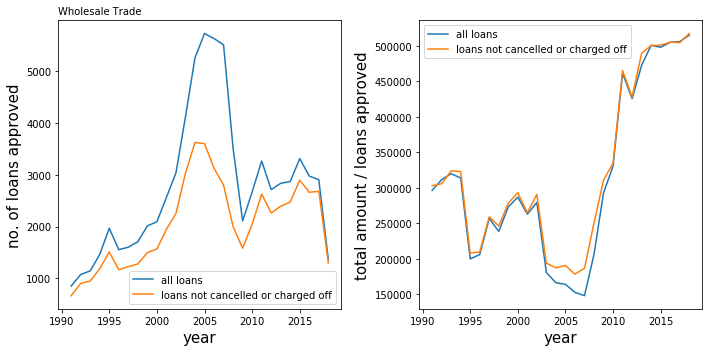

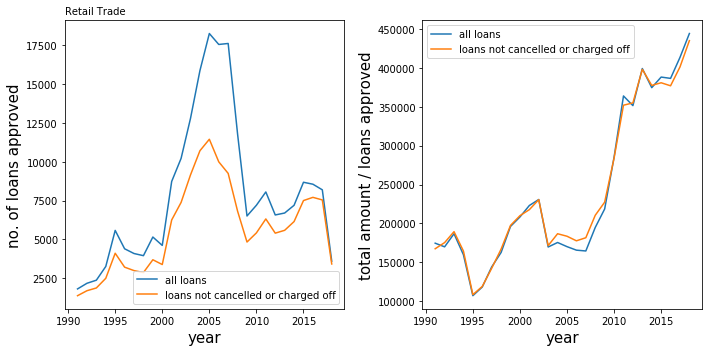

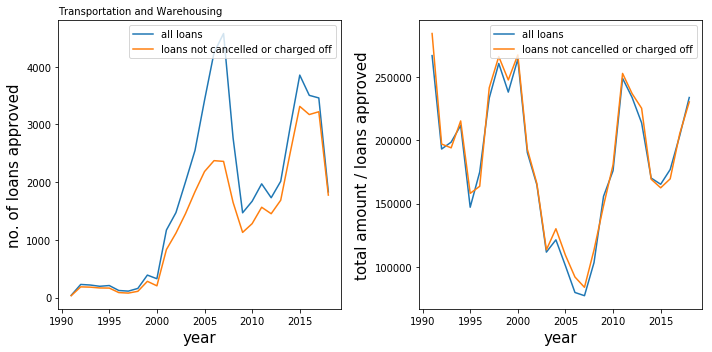

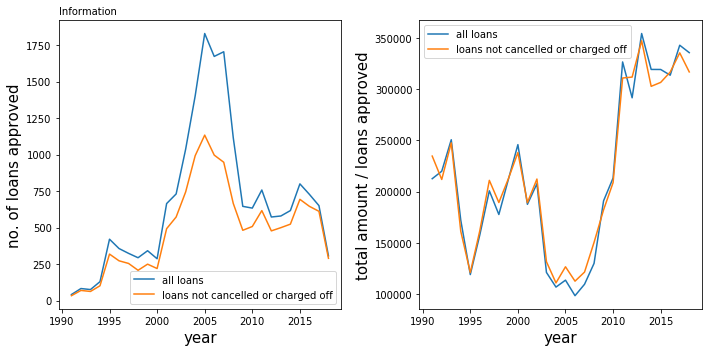

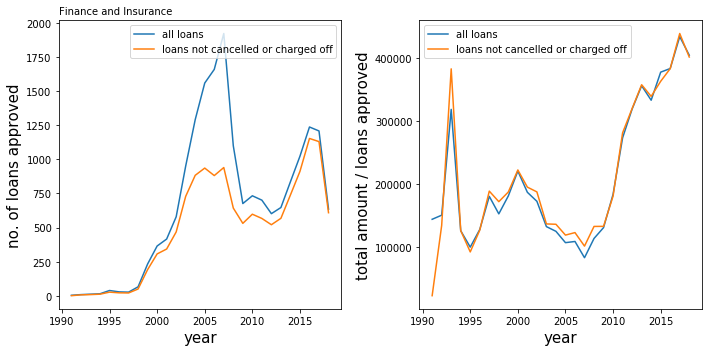

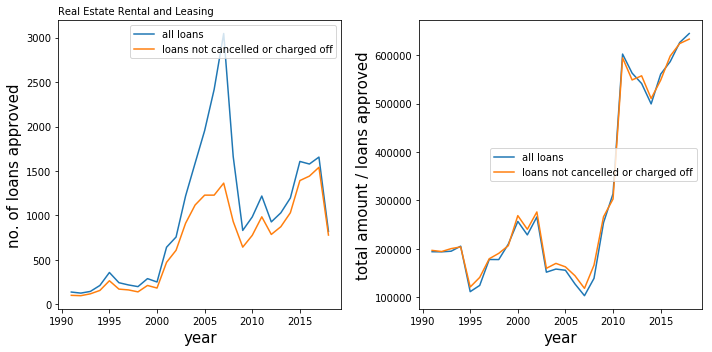

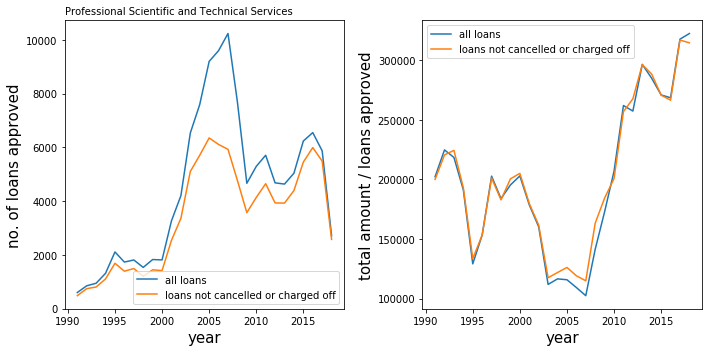

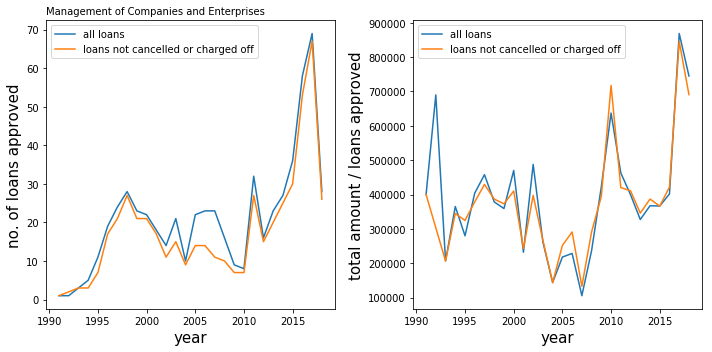

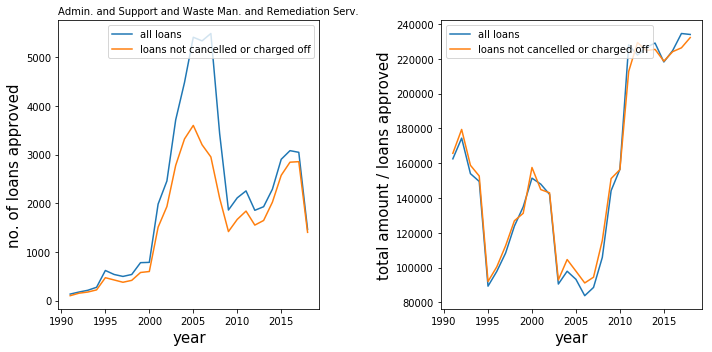

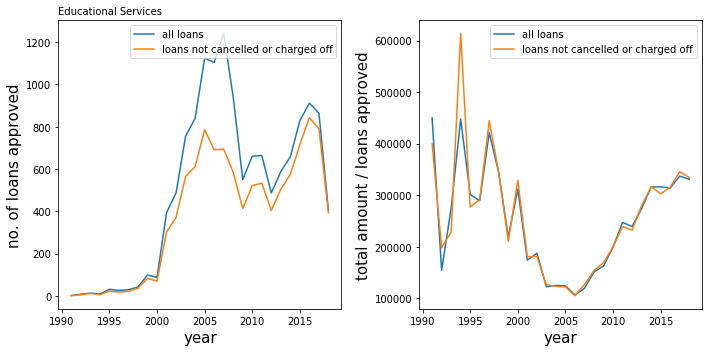

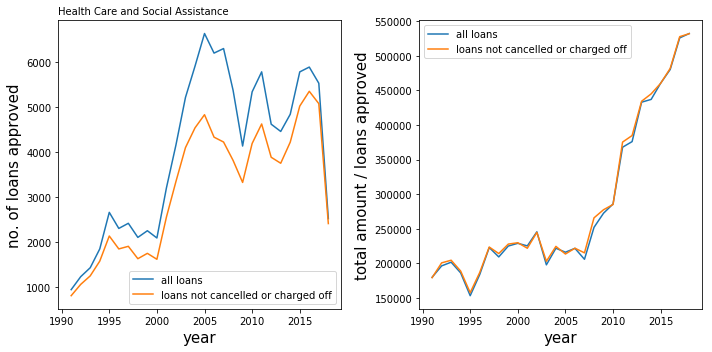

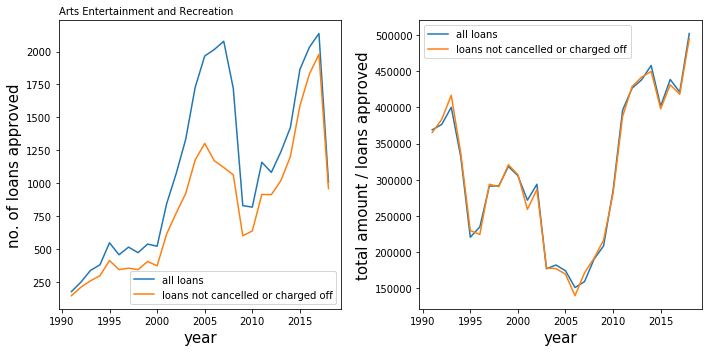

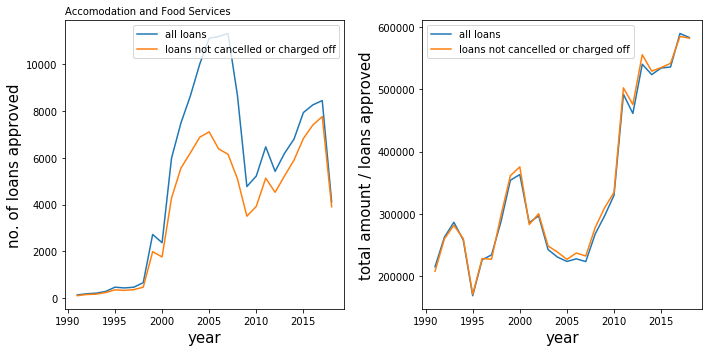

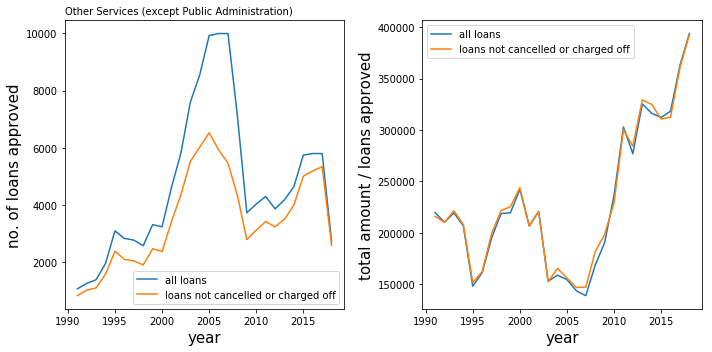

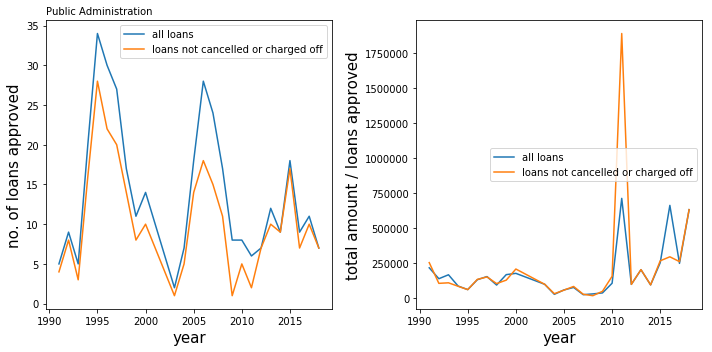

In [54]:
for indust in Industries.keys():
    ind_data = sbloan_data[sbloan_data['Industry']==indust]
    plottingtrends(ind_data, indust)

All industries in one plot. 

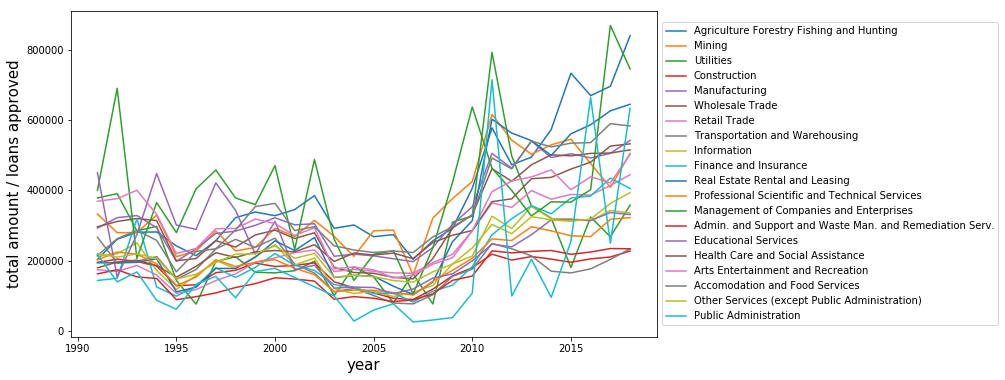

In [46]:
plt.figure(figsize=(15,6))
ax = plt.subplot(111)
for indust in Industries.keys():
    loan_data = sbloan_data[sbloan_data['Industry']==indust]
    yearly = loan_data[['ApprovalFiscalYear', 'GrossApproval']].groupby('ApprovalFiscalYear', as_index = False).count()
    yearly_sum = loan_data[['ApprovalFiscalYear', 'GrossApproval']].groupby('ApprovalFiscalYear', as_index = False).sum()
    plt.plot(yearly_sum.ApprovalFiscalYear, yearly_sum.GrossApproval/yearly.GrossApproval, label = indust)
plt.xlabel('year', fontsize=15)
plt.legend(loc = 'right')
plt.ylabel('total amount / loans approved', fontsize=15)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


Uses plotly library to plot the previous plot on an interactive platfrom where one can toggle between the different industries.

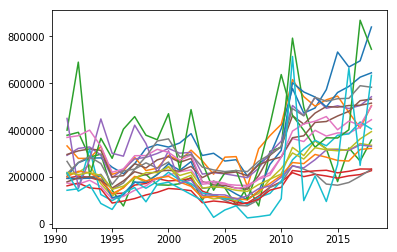

In [58]:
import plotly.plotly as py
import plotly.graph_objs as go

colors = ['RGB(61,89,171)','RGB(255,127,36)','RGB(69,139,0)','RGB(238,44,44)','RGB(178,58,238)', 'RGB(139,136,120)',\
         'RGB(255,110,180)','RGB(139,134,78)','RGB(102,205,0)','RGB(100,149,237)','RGB(115,115,115)','RGB(255,106,106)',\
         'RGB(32,178,170)','RGB(139,37,0)','RGB(142,142,56)','RGB(0,128,128)','RGB(205,205,0)','RGB(128,0,128)',\
          'RGB(51,161,201)','RGB(255,165,0)']


i = 0
data= []
for indust in list(Industries.keys()):
    loan_data = sbloan_data[sbloan_data['Industry']==indust]
    yearly = loan_data[['ApprovalFiscalYear', 'GrossApproval']].groupby('ApprovalFiscalYear', as_index = False).count()
    yearly_sum = loan_data[['ApprovalFiscalYear', 'GrossApproval']].groupby('ApprovalFiscalYear', as_index = False).sum()
    plt.plot(yearly_sum.ApprovalFiscalYear, yearly_sum.GrossApproval/yearly.GrossApproval, label = indust)
# Creating trace1
    trace1 = go.Scatter(
                        x = yearly_sum.ApprovalFiscalYear,
                        y = yearly_sum.GrossApproval/yearly.GrossApproval,
                        mode = "lines",
                        name = indust,
                        marker = dict(color = colors[i]),
                        text= indust)
    data.append(trace1)
    i = i+1

layout = dict(title = 'Industry trends over time',
              xaxis= dict(title= 'Year',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'Total amount / Loans Approved',ticklen= 5,zeroline= False),
              hovermode = 'closest'
             )
fig = dict(data = data, layout = layout)
config = {'scrollZoom': True, 'displayModeBar': True}
py.iplot(fig, filename='Industry_trends', config=config)

Checks how the number of jobs supported changes over time. These numbers are selfreported, so not the most reliable.

,ApprovalFiscalYear,GrossApproval
0,1991,4364883401
1,1992,5931034262
2,1993,6755154761
3,1994,8227462298
4,1995,8312715367
5,1996,7773817254
6,1997,9569905994
7,1998,9103404956
8,1999,10237713759
9,2000,10622974792


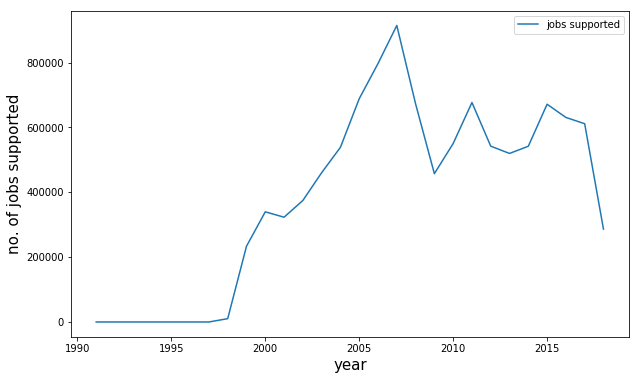

In [258]:
plt.figure(figsize=(10,6))
yearly_jobs = sbloan_data[['ApprovalFiscalYear', 'JobsSupported']].groupby('ApprovalFiscalYear', as_index = False).sum()
yearly = sbloan_data[['ApprovalFiscalYear', 'GrossApproval']].groupby('ApprovalFiscalYear', as_index = False).sum()
#plt.plot(yearly.ApprovalFiscalYear, yearly.GrossApproval, label = 'all loans')
plt.plot(yearly_jobs.ApprovalFiscalYear, yearly_jobs.JobsSupported, label = 'jobs supported')
plt.legend()
plt.xlabel('year', fontsize=15)
plt.ylabel('no. of jobs supported', fontsize=15)
yearly


A sample distribution of loan amounts for a given set of inputs. Have to match this with a distribution and do prediction for future events.

Text(0,0.5,'Frequency')

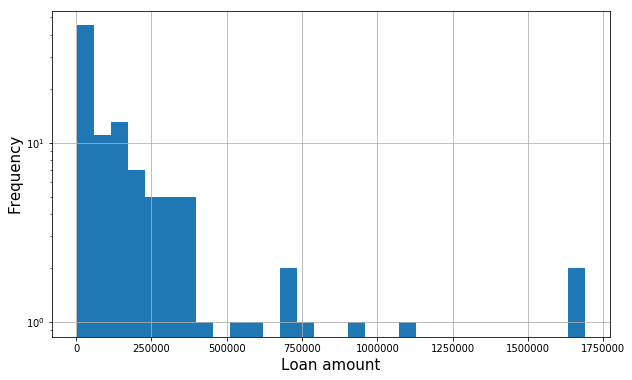

In [259]:
plt.figure(figsize=(10,6))
naics_hl = 23
state = 'MI'
year = 2010
naics_mask = sbloan_data['Industry'] == naicsCode_highlevel[naics_hl]
state_mask = sbloan_data['ProjectState'] == state
year_mask = sbloan_data['ApprovalFiscalYear'] == year
filtered = sbloan_data[naics_mask & state_mask & year_mask]
filtered['GrossApproval'].hist(bins=30, log = True)
plt.xlabel('Loan amount', fontsize=15)
plt.ylabel('Frequency', fontsize=15)